## Vehicle Detection Project

Detect bounding boxes of vehicles

---
## Input data

In [1]:
import os
import glob
subdirs = os.listdir('./vehicles')
cars = []
for s in subdirs:
    if "DS" in s:
        continue
    print('adding from ',s)
    cars.extend(glob.glob('./vehicles/'+s+'/*'))
print('found ',len(cars))
subdirs = os.listdir('./non-vehicles')
notcars = []
for s in subdirs:
    if "DS" in s:
        continue
    print('adding from ',s)
    notcars.extend(glob.glob('./non-vehicles/'+s+'/*'))
print('found ',len(notcars))


adding from  GTI_Far
adding from  GTI_Left
adding from  GTI_MiddleClose
adding from  GTI_Right
adding from  KITTI_extracted
found  8792
adding from  Extras
adding from  GTI
found  8968


## All imports

In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split

## Get features - HOG

In [3]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

## Get features - Spatial

In [4]:
def bin_spatial(img,size=(32,32)):
    ch1 = cv2.resize(img[:,:,0],size).ravel()
    ch2 = cv2.resize(img[:,:,1],size).ravel()
    ch3 = cv2.resize(img[:,:,2],size).ravel()
    return np.hstack((ch1,ch2,ch3))

## Get features - Color histogram

In [5]:
def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

## Get full feature vector

In [6]:
def extract_features_one(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, vis=False):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            if (vis==True):
                hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=True, feature_vec=True)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)

        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    if (vis==True):
        return np.concatenate(img_features), hog_image
    else:
        return np.concatenate(img_features)

## For all files

In [7]:
def extract_features_all(files, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    features = []
    for file in files:
        img = mpimg.imread(file)
        img_features = extract_features_one(img, color_space, spatial_size,hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel,
                        spatial_feat, hist_feat, hog_feat, vis=False)
        features.append(img_features)
    return features        

## Sliding window

In [8]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

## Draw boxes

In [9]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

## Search windows for image

In [10]:
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using extract_features_one()
        features = extract_features_one(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

## Plot

In [11]:
def viz(fig,rows,cols,imgs,titles):
    for i,img in enumerate(imgs):
        plt.subplot(rows,cols,i+1)
        plt.title(i+1)
        dims = len(img.shape)
        if dims<3:
            plt.imshow(img,cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])

## Hyperparams

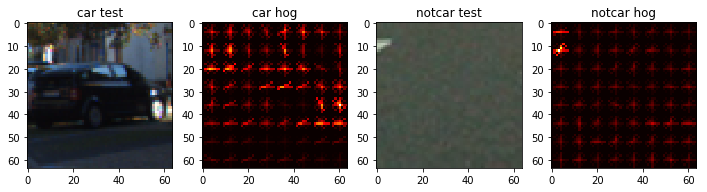

In [12]:
%matplotlib inline

color_space = 'RGB'
orient= 6
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0
spatial_size = (16,16)
hist_bins = 16
spatial_feat = True
hist_feat = True
hog_feat = True

car_test = mpimg.imread(cars[np.random.randint(0,len(cars))])
notcar_test = mpimg.imread(notcars[np.random.randint(0,len(notcars))])

car_features, car_hog_image = extract_features_one(car_test, color_space=color_space, spatial_size=spatial_size, 
                                                   hist_bins=hist_bins, orient=orient, 
                                                   pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                                                   spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat, vis=True)

notcar_features, notcar_hog_image = extract_features_one(notcar_test, color_space=color_space, spatial_size=spatial_size, 
                                                   hist_bins=hist_bins, orient=orient, 
                                                   pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                                                   spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat, vis=True)

imgs = [car_test,car_hog_image,notcar_test,notcar_hog_image]
titles = ['car test', 'car hog', 'notcar test', 'notcar hog']
fig=plt.figure(figsize=(12,3))
viz(fig,1,4,imgs,titles)

## Setup features and train/test for training

In [13]:
color_space='YCrCb'
orient = 9
hog_channel = 'ALL'
spatial_size=(32,32)
hist_bins=32

#n_samples = 1000
#idxs = np.random.randint(0,len(cars),n_samples)
test_c = cars #np.array(cars)[idxs]
test_nc = notcars #np.array(notcars)[idxs]

start = time.time()

c_f = extract_features_all(test_c, color_space=color_space, spatial_size=spatial_size, 
                           hist_bins=hist_bins, orient=orient, 
                           pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                           spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
nc_f = extract_features_all(test_nc, color_space=color_space, spatial_size=spatial_size, 
                           hist_bins=hist_bins, orient=orient, 
                           pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                           spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

end = time.time()
print(round(end-start,2), 'sec for feature extraction')

X = np.vstack((c_f,nc_f)).astype(np.float64)
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

y = np.hstack((np.ones(len(c_f)), np.zeros(len(nc_f))))

r = np.random.randint(0,100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X,y,test_size=0.1,random_state=r)


172.97 sec for feature extraction


## Training

In [14]:
svc = LinearSVC()


start = time.time()

svc.fit(X_train,y_train)
acc = round(svc.score(X_test,y_test),4)

end = time.time()
print('accuracy =', acc)
print(end-start, 'sec for training')


accuracy = 0.991
48.0831139087677 sec for training


## Run on test images

2.7203149795532227 sec
1.733227014541626 sec
2.1141982078552246 sec
2.762446880340576 sec
1.923232078552246 sec
1.6495120525360107 sec


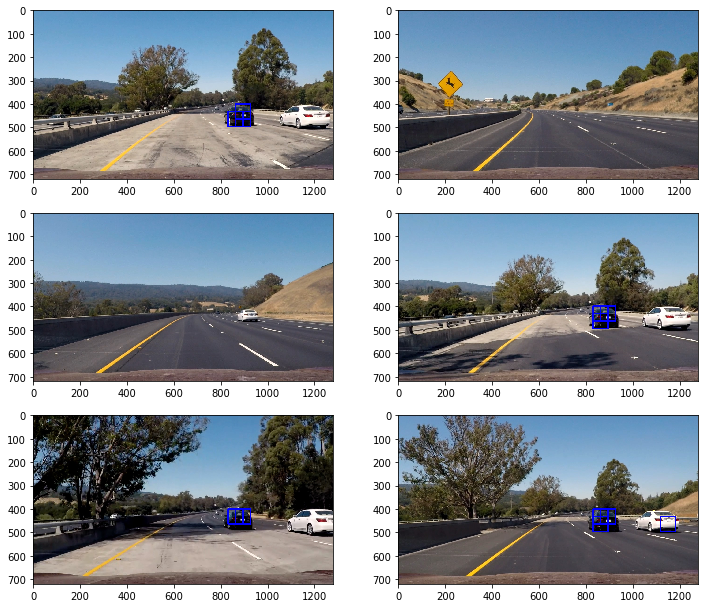

In [15]:
test_files=glob.glob('./test_images/*')
imgs = []
titles = []
y_start_stop = [400, 660]
x_start_stop = [None, None]
overlap=0.5
for f in test_files:
    start = time.time()
    img = mpimg.imread(f)
    cp = np.copy(img)
    img = img.astype(np.float32)/255
    
    windows = slide_window(img,x_start_stop=x_start_stop,y_start_stop=y_start_stop,
                          xy_window=(64,64), xy_overlap=(overlap,overlap))
    hot = search_windows(img,windows,svc,X_scaler,color_space=color_space,
                        spatial_size=spatial_size,hist_bins=hist_bins,
                        orient=orient,pix_per_cell=pix_per_cell,
                        cell_per_block=cell_per_block,
                        hog_channel=hog_channel,spatial_feat=spatial_feat,
                        hist_feat=hist_feat,hog_feat=hog_feat)
    overlay = draw_boxes(cp, hot, color=(0,0,255), thick=6)
    imgs.append(overlay)
    titles.append('')
    end = time.time()
    print(end-start, 'sec')

fig = plt.figure(figsize=(12,18))
viz(fig,5,2,imgs,titles)
    

## Compute HOG one-time and subsample

In [16]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def search_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):

    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    heat_map = np.zeros_like(img[:,:,0])
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                heat_map[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] += 1
            
    return draw_img, heat_map

## Threshold heatmap and draw bounding boxes

In [17]:
from scipy.ndimage.measurements import label

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

## Run on test images

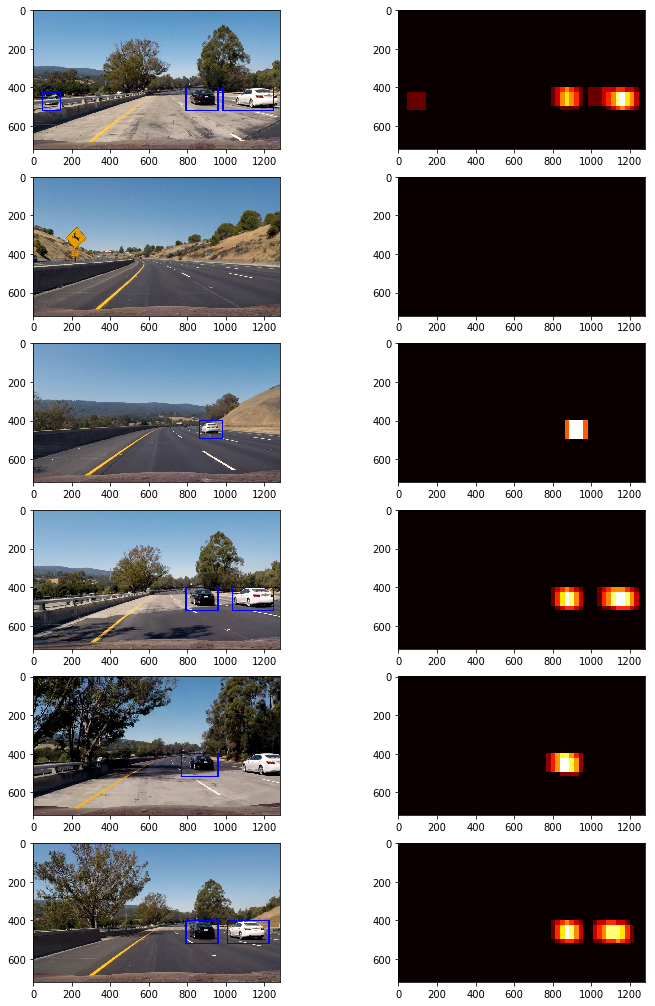

In [18]:
out_images = []
out_maps = []
out_titles = []
out_boxes = []

ystart = 400
ystop = 656
scale = 1.5

test_files=glob.glob('./test_images/*')
for f in test_files:
    img = mpimg.imread(f)
    out_img, heat_map = search_cars(img, ystart, ystop, scale, svc, X_scaler, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, spatial_size=spatial_size, hist_bins=hist_bins)
    labels = label(heat_map)
    draw_img = draw_labeled_bboxes(np.copy(img),labels)
    out_images.append(draw_img)
    out_titles.append('')
    out_images.append(heat_map)
    out_titles.append('')

fig = plt.figure(figsize=(12,24))
viz(fig,8,2,out_images,out_titles)


## Average across frames

In [19]:
class heatmaps():
    def __init__(self):
        self.all_detected = []
    
    def add(self,heatmap):
        self.all_detected.append(heatmap)
    
    def last_N(self,N):
        num = len(self.all_detected)
        assert(num>0)
        result = np.zeros_like(self.all_detected[0])
        if (num<N):
            for i in range(0,num):
                result = result + self.all_detected[i]
        else:
            for i in range(num-N,num):
                result = result + self.all_detected[i]
        return result

## Frame processing function

In [22]:
all_maps = heatmaps()
scale = 1.5

def process_image(img):
    out_img, heat_map = search_cars(img, ystart, ystop, scale, svc, X_scaler, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, spatial_size=spatial_size, hist_bins=hist_bins)
    all_maps.add(heat_map)
    heat_map = all_maps.last_N(30)
    heat_map = apply_threshold(heat_map,15)
    labels=label(heat_map)
    draw_img=draw_labeled_bboxes(np.copy(img),labels)
    #cv2.rectangle(draw_img, (0,400), (1280,656), (0,0,255), 6)
    return draw_img

## Test on video

In [23]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

test_output = './project_out.mp4'
clip = VideoFileClip("./project_video.mp4")
test_clip = clip.fl_image(process_image)
test_clip.write_videofile(test_output,audio=False)

[MoviePy] >>>> Building video ./project_out.mp4
[MoviePy] Writing video ./project_out.mp4


100%|█████████▉| 1260/1261 [11:12<00:00,  1.82it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_out.mp4 

